<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_part2_07b_lsuv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Note to self: capture as much telemetry at every stage in & out as possible, otherwise you're reasoning about your illusions not what's in the system
# 2nd next would be namespaces & var names from different visibility zones confused by me --> learn to break this into smaller pieces
# and then just typos --> code should be readable

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html -q

In [0]:
# Note to self: check the code before writing BS notes. (v1: needed for hooks to match expected interface (not true))
import torch; torch.__version__

'1.1.0.dev20190414'

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Copypasta from prev notebook with some minor revisions

In [0]:
def sorta_import(name):
  import urllib.request
  import os
  a = urllib.request.urlopen(f'https://raw.githubusercontent.com/fastai/fastai_docs/master/dev_course/dl2/exp/{name}.py')
  assert a.code == 200
  os.makedirs('exp', exist_ok=True)
  with open(f'exp/{name}.py', 'wb') as f:
    f.write(a.read())
  assert a.code == 200

def load_modules_up_to(n_inclusive):
  for i in range(n_inclusive + 1):
    try:
      sorta_import(f'nb_0{i}')
    except:
      print(f"Problem importing {i}")
      raise

load_modules_up_to(6)
sorta_import('nb_05b')
from exp.nb_06 import *

In [0]:
from torch.utils.data import *

x_train,y_train,x_valid,y_valid = get_data()
n_classes = len(y_train.unique())
batch_size = 512


def _single_batch(self):
  return next(iter(self.train_dl))

DataBunch.single_batch = _single_batch

# copypasta from 07_batch_norm
def get_my_data(batch_size=512, limit=slice(None, None, None)):
  if isinstance(batch_size, int):
    batch_size = (batch_size, batch_size)

  trn_batch_size, val_batch_size = batch_size
  train_ds = TensorDataset(x_train[limit], y_train[limit])
  valid_ds = TensorDataset(x_valid, y_valid)
  train_dl = DataLoader(train_ds, batch_size=trn_batch_size, shuffle = True)
  valid_dl = DataLoader(valid_ds, batch_size=val_batch_size, shuffle = False)

  data = DataBunch(train_dl, valid_dl)
  return data

from collections import namedtuple
Stats = namedtuple('Stats', 'mean, std')

def stats(x):
  return Stats(x.mean(), x.std())

train_stats = stats(x_train)
valid_stats = stats(x_valid)
train_stats, valid_stats

def normalize(x, s):
  return (x - s.mean) / s.std

class MyConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    return x
  
  @property
  def weight(self):
    return self.conv.weight
  
  @property
  def bias(self):
    return self.conv.bias
  
  @weight.setter
  def weight(self, new_weight):
    assert self.conv.weight.shape == new_weight.shape
    self.conv.weight.data = new_weight
    
  @bias.setter
  def bias(self, new_bias):
    assert self.conv.bias.shape == new_bias.shape
    self.conv.bias.data = new_bias

def my_conv_no_bn(in_channels, out_channels, kernel_size=3, stride=2, padding=1):
  return MyConv(in_channels, out_channels, kernel_size, stride, padding);

def get_my_model(conv_func=my_conv_no_bn):
  return nn.Sequential(
      Lambda(lambda m: normalize(m, train_stats)),
      Lambda(lambda m: m.view(-1, 1, 28, 28)),
      conv_func( 1, 8,  kernel_size=5, stride=2, padding=2),
      conv_func( 8, 16, kernel_size=3),
      conv_func(16, 32),
      conv_func(32, 32),
      nn.AdaptiveAvgPool2d(1),
      Lambda(lambda m: m.squeeze(-1).squeeze(-1)),
      nn.Linear(in_features = 32, out_features = n_classes)
  )

data = get_my_data()
model = get_my_model()

In [0]:
x, y = data.single_batch()

In [0]:
input = model[1](model[0](x))
stats(input)

Stats(mean=tensor(-0.0137), std=tensor(0.9844))

In [0]:
output = model[2](input)
stats(output)

Stats(mean=tensor(0.2009, grad_fn=<MeanBackward0>), std=tensor(0.4311, grad_fn=<StdBackward0>))

In [0]:
module = model[2]
eps = 0.01

module.bias = torch.zeros_like(module.bias)
for n_iter in range(5):
  output = module(input)
  std = output.std().detach()
  good_stats = (std - 1).abs() <= eps
  if good_stats:
    break
    
  module.weight = module.weight / std

stats(module.weight), stats(output)

(Stats(mean=tensor(0.0247, grad_fn=<MeanBackward0>), std=tensor(0.2844, grad_fn=<StdBackward0>)),
 Stats(mean=tensor(0.4681, grad_fn=<MeanBackward0>), std=tensor(1., grad_fn=<StdBackward0>)))

# v1

In [0]:
def zero_bias(module, mean):
  return torch.zeros_like(module.bias)

def no_op_bias(module, mean):
  return module.bias

def lsuv_module_(module, input, bias_strategy=None, eps=0.001):
  # Note to self: defaulting in the func definition requires copypasting the thing in the consumers passing stuff through (e.g. lsuv_model_ calling this has to know about defualting)
  if not bias_strategy:
    bias_strategy = no_op_bias

  if not hasattr(module, 'weight'):
    return

  for n_iter in range(5):
    output = module(input)
    std = output.std().detach()
    mean = output.mean().detach()
    good_stats = (std - 1).abs() <= eps
    if good_stats:
      break

    module.bias.data = bias_strategy(module, mean)
    module.weight.data = module.weight.data / std

In [0]:
module = model[2]
input = model[1](model[0](x))
with torch.no_grad():
  module.weight.uniform_(-0.01, 1.01)
lsuv_module_(module, input)

output = module(input)

test_near(output.std(), tensor(1.))

In [0]:
model = get_my_model()
def lsuv_model_(model, bias_strategy=None, verbose=False):
  input = x
  for module in model:  
    lsuv_module_(module, input, bias_strategy=bias_strategy)
    output = module(input)
    input = output
    if verbose: print(f"{stats(output)} (module: {module.__class__.__name__})")
    
lsuv_model_(model, verbose=True)

Stats(mean=tensor(-0.0137), std=tensor(0.9844)) (module: Lambda)
Stats(mean=tensor(-0.0137), std=tensor(0.9844)) (module: Lambda)
Stats(mean=tensor(0.4021, grad_fn=<MeanBackward0>), std=tensor(0.9991, grad_fn=<StdBackward0>)) (module: MyConv)
Stats(mean=tensor(0.4210, grad_fn=<MeanBackward0>), std=tensor(1.0000, grad_fn=<StdBackward0>)) (module: MyConv)
Stats(mean=tensor(0.4912, grad_fn=<MeanBackward0>), std=tensor(1.0000, grad_fn=<StdBackward0>)) (module: MyConv)
Stats(mean=tensor(0.6290, grad_fn=<MeanBackward0>), std=tensor(1.0000, grad_fn=<StdBackward0>)) (module: MyConv)
Stats(mean=tensor(0.6290, grad_fn=<MeanBackward0>), std=tensor(0.6124, grad_fn=<StdBackward0>)) (module: AdaptiveAvgPool2d)
Stats(mean=tensor(0.6290, grad_fn=<MeanBackward0>), std=tensor(0.6124, grad_fn=<StdBackward0>)) (module: Lambda)
Stats(mean=tensor(-0.6738, grad_fn=<MeanBackward0>), std=tensor(1.0000, grad_fn=<StdBackward0>)) (module: Linear)


In [0]:
# copypasta from 07_batch_norm
class HistHook():
  def __init__(self, min=-10, max=10, bins=50):
    self.bins = bins
    self.min = min
    self.max = max
  
  def __call__(self, hook_param, module, input, output):
    output = output.clone().cpu().detach()
    if not hasattr(hook_param, 'histograms'):
      hook_param.histograms = []
      hook_param.averages = []
      hook_param.stds = []
    hook_param.histograms.append(torch.histc(output, bins=self.bins, min=self.min, max=self.max))
    hook_param.averages.append(torch.mean(output))
    hook_param.stds.append(torch.std(output))
    
  def plot_percentage_withinbounds(self, hists, min_bound, max_bound, ax=None):
    data = self.percentage_within_bounds(hists, min_bound, max_bound)
    if not ax: ax = plt.subplot()
    ax.set_ylim(0, 1)
    ax.plot(data)

  def total_percentage_within_bounds(self, hists, min_bound, max_bound):
    all_hists_sum = torch.stack(hists).sum()
    selected_bins_series = self._series_bins_between(hists, min_bound, max_bound)
    selected_bins_sum = selected_bins_series.sum()
    return (selected_bins_sum / all_hists_sum.float()).item()
  
  def percentage_within_bounds(self, hists, min_bound, max_bound):
    selected_bins_series = self._series_bins_between(hists, min_bound, max_bound)
    all_hists = torch.stack(hists).t()
    return (selected_bins_series.sum(0).float() / all_hists.sum(dim=0).float()).squeeze(0)

  def _series_bins_between(self, hists, min_bound, max_bound):
    assert min_bound < max_bound
    assert min_bound >= self.min
    assert max_bound <= self.max

    assert len(hists) > 0
    
    bin_width = (self.max-self.min) / self.bins
    right_bounds = self.min + torch.zeros(self.bins).fill_(bin_width).cumsum(dim=0)
    left_bounds = right_bounds - bin_width

    indexes = (left_bounds >= min_bound)*(right_bounds <= max_bound)
    assert (indexes > 0).any().item(), f"Too narrow of a range, no bins fully selected (single bin is {bin_width})"
    all_hists = torch.stack(hists).t()
    return all_hists[indexes]

In [0]:
# copypasta from 07_batch_norm
def draw_activations_around_zero(hist_hook, hooks_list):
  hist_serlies_list = list(map(lambda hook: hook.histograms, hooks_list))
  fig, axz = plt.subplots(2, 5, figsize=(18,3))
  for hist, ax, idx in zip(hist_serlies_list, axz.flatten(), range(len(hist_serlies_list))):
    ax.set_title(f'Layer {idx}')
    hist_hook.plot_percentage_withinbounds(hist, -0.4, 0.4, ax=ax)
    
def draw_activation_hists(hist_hook, hooks_list):
  hist_serlies_list = list(map(lambda hook: hook.histograms, hooks_list))
  fig, axz = plt.subplots(2, 5, figsize=(18,3))
  for hist_series, ax, idx in zip(hist_serlies_list, axz.flatten(), range(len(hist_serlies_list))):
    hist_series = torch.stack(hist_series).t().log1p()
    ax.axis('off')
    ax.set_title(f'Layer {idx}')
    ax.imshow(hist_series, cmap='plasma', origin='lower', interpolation='none')

def draw_avgs(hooks_list, y_bounds=(-5,5)):
  avg_serlies_list = list(map(lambda hook: hook.averages, hooks_list))
  fig, axz = plt.subplots(1, 2, figsize=(18,3))
  axz = axz.flatten()
  axz[0].set_title(f'Averages')
  for avg_series in avg_serlies_list:
    axz[0].plot(avg_series)
  axz[0].set_ylim(*y_bounds)
  axz[0].legend(range(len(avg_serlies_list)))
  
  std_serlies_list = list(map(lambda hook: hook.stds, hooks_list))
  axz[1].set_ylim(*y_bounds)
  axz[1].set_title(f'Std by layer')
  for series in std_serlies_list:
    axz[1].plot(series)
  axz[1].legend(range(len(std_serlies_list)))

def train_and_show_telemetry(model, lr = 0.4):  
  loss_func = F.cross_entropy
  opt = optim.SGD(model.parameters(), lr)
  learner = Learner(model, opt, loss_func, data)

  cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
  runner = Runner(cbfs)

  hist_hook = HistHook()
  with Hooks(model, hist_hook) as hooks:
    runner.fit(3, learner)
    
  draw_avgs(hooks)
  draw_activations_around_zero(hist_hook, hooks)
  draw_activation_hists(hist_hook, hooks)

## Experiment v1, bias - regular init, weights - normalized

train: [2.217413125, tensor(0.1782, device='cuda:0')]
valid: [1.51367861328125, tensor(0.5609, device='cuda:0')]
train: [0.715141328125, tensor(0.7659, device='cuda:0')]
valid: [0.2173185546875, tensor(0.9305, device='cuda:0')]
train: [0.2078487890625, tensor(0.9379, device='cuda:0')]
valid: [0.13914095458984374, tensor(0.9600, device='cuda:0')]


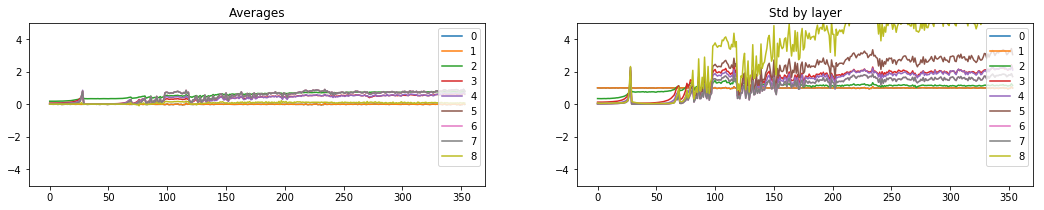

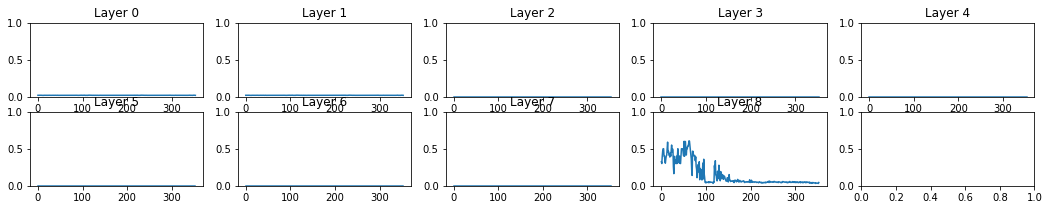

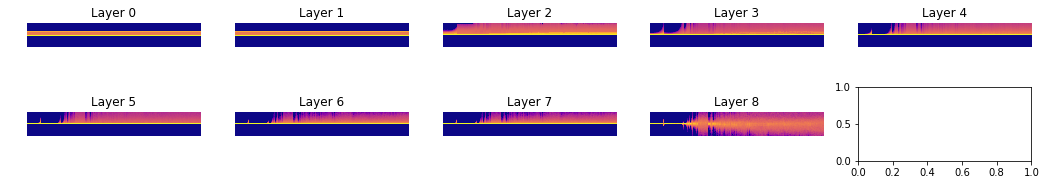

In [0]:
train_and_show_telemetry(get_my_model())

train: [1.61889921875, tensor(0.4564, device='cuda:0')]
valid: [0.43801875, tensor(0.8520, device='cuda:0')]
train: [0.32398234375, tensor(0.8996, device='cuda:0')]
valid: [0.18122794189453126, tensor(0.9468, device='cuda:0')]
train: [0.175426171875, tensor(0.9459, device='cuda:0')]
valid: [0.1201230712890625, tensor(0.9657, device='cuda:0')]


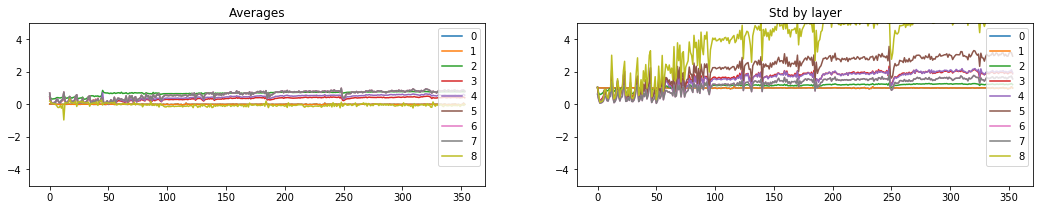

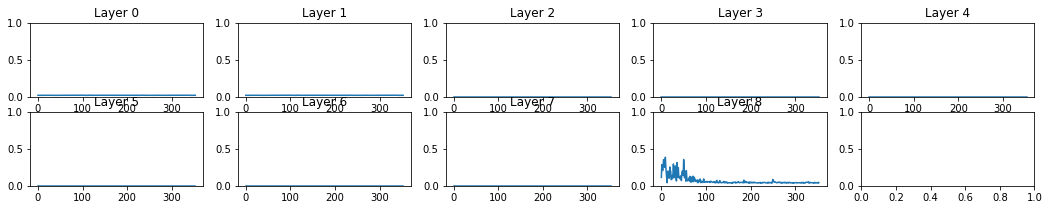

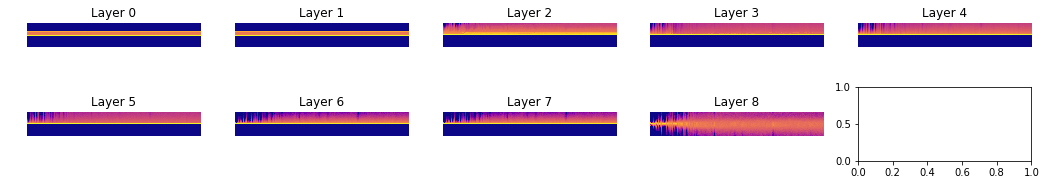

In [0]:
model = get_my_model()
lsuv_model_(model, bias_strategy=no_op_bias)
train_and_show_telemetry(model)

## Experiment v2: bias - zero, weights - normalized

train: [2.2838928125, tensor(0.1580, device='cuda:0')]
valid: [2.1055498046875, tensor(0.2491, device='cuda:0')]
train: [1.305584453125, tensor(0.5573, device='cuda:0')]
valid: [0.3275278076171875, tensor(0.8995, device='cuda:0')]
train: [0.3497923828125, tensor(0.8909, device='cuda:0')]
valid: [0.201629052734375, tensor(0.9393, device='cuda:0')]


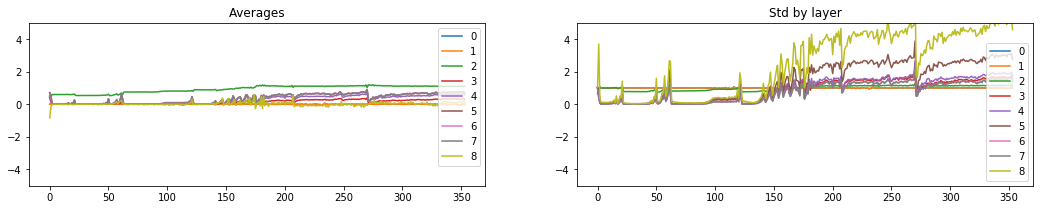

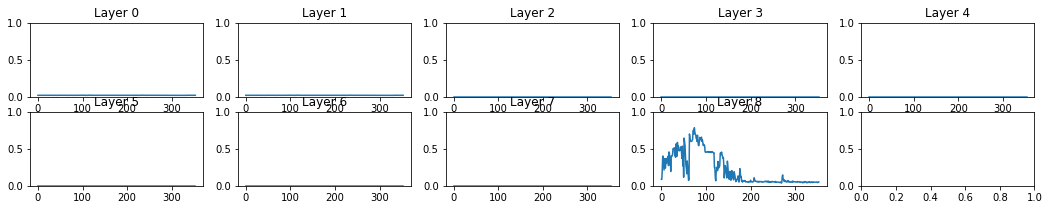

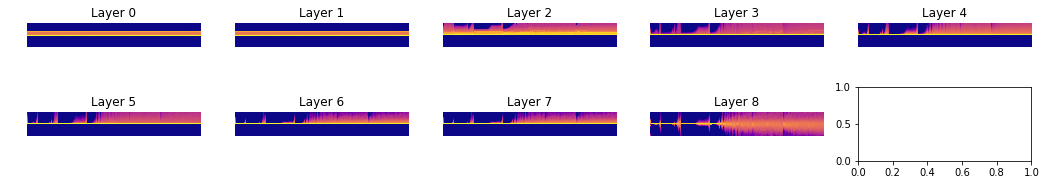

In [0]:
model = get_my_model()
lsuv_model_(model, bias_strategy=zero_bias)
train_and_show_telemetry(model)

train: [2.30803640625, tensor(0.1110, device='cuda:0')]
valid: [2.301751171875, tensor(0.1064, device='cuda:0')]
train: [2.3015184375, tensor(0.1131, device='cuda:0')]
valid: [2.30301328125, tensor(0.1064, device='cuda:0')]
train: [2.3016065625, tensor(0.1136, device='cuda:0')]
valid: [2.302148828125, tensor(0.1064, device='cuda:0')]


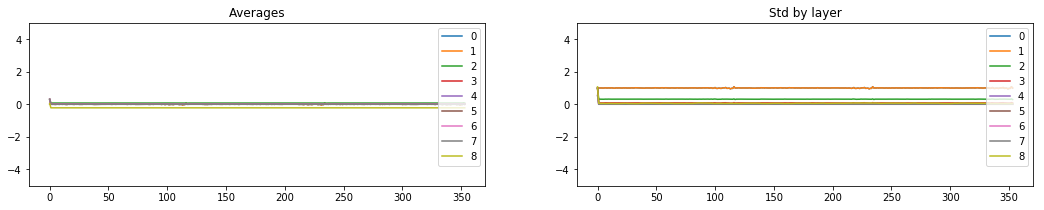

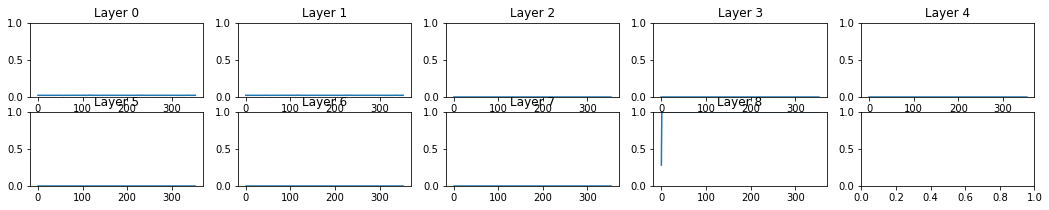

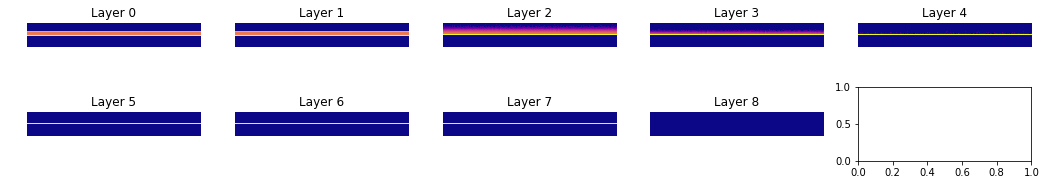

In [0]:
def fast_ai_normalize_bias(module, output_mean):
  return module.bias - output_mean

model = get_my_model()
lsuv_model_(model, bias_strategy=fast_ai_normalize_bias)
train_and_show_telemetry(model)

In [0]:
def lsuv_module_(module, input_batch, bias_strategy=None, eps=0.001):
  if not bias_strategy:
    bias_strategy = no_op_bias

  # Note to self: having this check outside as done in the original notebook is better, filtering can evolve separately from the func
  # also initializing conv + relu blocks doesn't seem to converge
  if not hasattr(module, 'weight'):
    return

  for n_iter in range(15):
    output = module(input_batch)
    std = output.std().detach()
    mean = output.mean().detach() # <-- Note to self: forgot to even be looking at this at first
    good_stats = ((std - 1).abs() <= eps) and (mean.abs() <= eps)
    if good_stats:
      break

    module.bias.data = bias_strategy(module, mean)
    module.weight.data = module.weight.data / std

## Experiment v3: bias - normalized, weights - normalized (discovered a bug invalidating all the previous ones)

train: [2.30563328125, tensor(0.1114, device='cuda:0')]
valid: [2.3032576171875, tensor(0.1064, device='cuda:0')]
train: [2.3015121875, tensor(0.1133, device='cuda:0')]
valid: [2.30379609375, tensor(0.1064, device='cuda:0')]
train: [2.3016809375, tensor(0.1127, device='cuda:0')]
valid: [2.3017478515625, tensor(0.1090, device='cuda:0')]


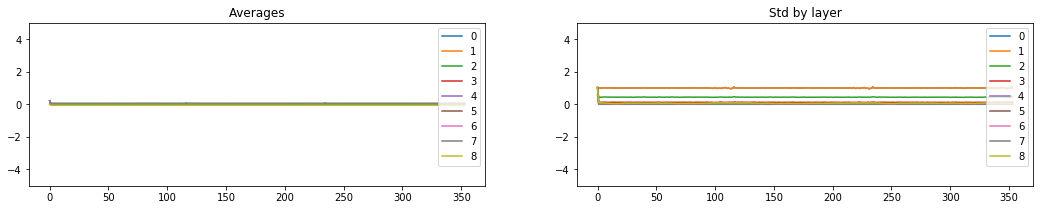

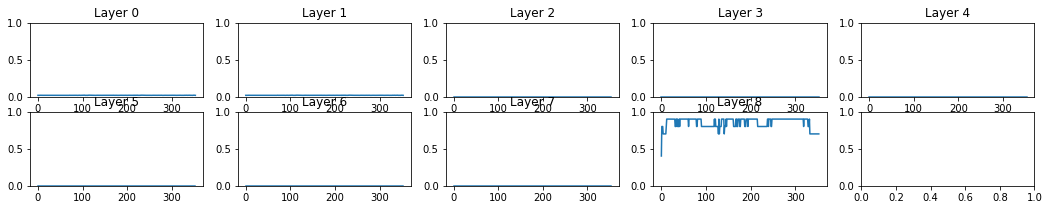

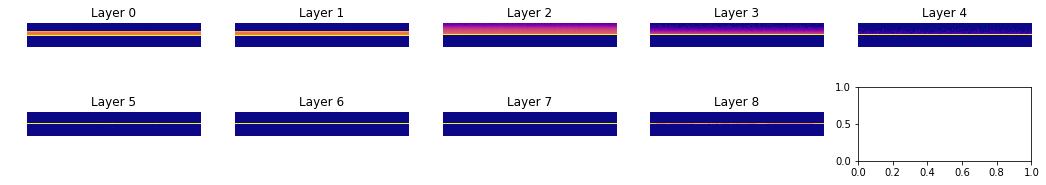

In [0]:
model = get_my_model()
lsuv_model_(model, bias_strategy=fast_ai_normalize_bias)
train_and_show_telemetry(model)

# v2: bias, then weights normalization (fast.ai style)

In [0]:
"""Note to self: tryin to adjust std & mean within the same cycle leads to the following cyclic behavior
(out_stds=[0.0739094614982605,
  14792.478515625,
  0.0739094614982605,
  ...],
 out_means[-0.0910581722855568,
  3295.766357421875,
  -0.0910581722855568,
  ...])
"""
from collections import defaultdict
def lsuv_module_v2_(model, module, model_input, eps = 1e-3, max_iterations=15, telemetry=None):
  if telemetry == None:
    telemetry = {}

  telemetry['hook_called'] = False
  telemetry['out_means'] = []
  telemetry['out_means_std'] = []
  telemetry['out_stds'] = []
  def _hook_func(hook, module, hooked_input, hooked_output):
    hooked_input = hooked_input[0]
    with torch.no_grad():
      if telemetry['hook_called']: return
      else: telemetry['hook_called'] = True

      telemetry['in_std'] = hooked_input[0].data.std().item()
      telemetry['in_mean'] = hooked_input[0].data.mean().item()
      for i in range(max_iterations):
        # Note to self: spent a while until figured model_input (named 'batch') should be here not hooked_input
        # Which was just a sign of module having to be here :)
        output = module(hooked_input)
        mean = output.data.mean().item()
        telemetry['out_means'].append(mean)
        if abs(mean) < eps:
          break

        module.bias -= mean

      for i in range(max_iterations):
        output = module(hooked_input)
        std = output.data.std().item()
        telemetry['out_stds'].append(std)
        telemetry['out_means_std'].append(output.data.mean().item())
        if abs(std-1) < eps:
          break

        module.weight.data /= std

  try:
    hook = Hook(module, _hook_func)
    model(model_input)
  finally:
    hook.remove()

model = get_my_model()
telemetry = {}
lsuv_module_v2_(model, model[2].conv, x, telemetry=telemetry)
test_eq(len(telemetry['out_stds']) > 0, True)
test_eq(len(telemetry['out_stds']) <= 6, True)

In [0]:
model = get_my_model()
module = model[2].conv
model_input = x
with torch.no_grad():
  module.weight.uniform_(-0.01, 1.01)
telemetry = {}
lsuv_module_v2_(model, module, model_input, telemetry=telemetry)

LAST = -1
assert abs(telemetry['out_stds'][LAST]  - 1) < 1, f"Got {telemetry['out_std'][LAST]}"
assert abs(telemetry['out_means'][LAST] - 0) < 5e-1, f"Got {telemetry['out_means'][LAST]}"
telemetry

{'hook_called': True,
 'in_mean': -0.07252306491136551,
 'in_std': 0.9052676558494568,
 'out_means': [0.2993396520614624, -3.6006072150485124e-06],
 'out_means_std': [-3.6006072150485124e-06,
  -0.22870250046253204,
  -0.2287944257259369],
 'out_stds': [8.048766136169434, 1.0028797388076782, 1.0000169277191162]}

In [0]:
# try that on another layer just in case
model = get_my_model()
module = model[4].conv
model_input = x
with torch.no_grad():
  module.weight.uniform_(-0.01, 1.01)
telemetry = {}
lsuv_module_v2_(model, module, model_input, telemetry=telemetry)

LAST = -1
assert abs(telemetry['out_stds'][LAST]  - 1) < 1e-2, f"Got {telemetry['out_stds'][LAST]}"
assert abs(telemetry['out_means'][LAST] - 0) < 5e-1, f"Got {telemetry['out_means'][LAST]}"

In [0]:
telemetry

{'hook_called': True,
 'in_mean': 0.1059107705950737,
 'in_std': 0.17088748514652252,
 'out_means': [5.8096160888671875, -9.462237358093262e-07],
 'out_means_std': [-9.462237358093262e-07,
  -4.489047527313232,
  -4.490518569946289],
 'out_stds': [4.369591236114502, 1.001104712486267, 1.0000026226043701]}

In [0]:
# Note to self: ocassionally everything (including std) blows up - probaby symptom of a bunch of typos I highlighted above
"""
{'hook_called': True,
 'in_mean': 0.13350103795528412,
 'in_std': 0.31056100130081177,
 'out_means': [-0.6157975792884827,
  -0.6648051142692566,
  -0.7179083228111267,
  -0.7758978605270386,
  -0.8395718336105347,
  -0.9095794558525085,
  -0.9864697456359863,
  -1.0706199407577515,
  -1.1627601385116577,
  -1.2633659839630127,
  -1.3729851245880127,
  -1.492328405380249,
  -1.6221446990966797,
  -1.7634220123291016,
  -1.9170736074447632],
 'out_stds': [5.931337833404541,
  4.665585041046143,
  4.465101718902588,
  4.422713279724121,
  4.4132490158081055,
  4.4111104011535645,
  4.410625457763672,
  4.410514831542969,
  4.410489082336426,
  4.4104838371276855,
  4.410483360290527,
  4.410483360290527,
  4.410483360290527,
  4.410483360290527,
  4.410483360290527]}
  
Sometimes even means improve
{'hook_called': True,
 'in_mean': 0.13350103795528412,
 'in_std': 0.31056100130081177,
 'out_means': [0.20555827021598816,
  0.19061143696308136,
  0.1765231341123581,
  0.163252055644989,
  0.1508423388004303,
  0.13928988575935364,
  0.1289495825767517,
  0.12015442550182343,
  0.1129942312836647,
  0.10674946010112762,
  0.10111616551876068,
  0.09586787223815918,
  0.09120269119739532,
  0.08697732537984848,
  0.08305281400680542],
 'out_stds': [0.33507010340690613,
  1.5245712995529175,
  0.8957370519638062,
  1.0342755317687988,
  0.9901800155639648,
  1.002934217453003,
  0.9991337060928345]}"""
telemetry

{'hook_called': True,
 'in_mean': 0.1059107705950737,
 'in_std': 0.17088748514652252,
 'out_means': [5.8096160888671875, -9.462237358093262e-07],
 'out_means_std': [-9.462237358093262e-07,
  -4.489047527313232,
  -4.490518569946289],
 'out_stds': [4.369591236114502, 1.001104712486267, 1.0000026226043701]}

In [0]:
model[2].conv.__class__ in [nn.Conv2d, nn.Linear]

True

In [0]:
def lsuv_model_(model, batch, telemetry=None, module_func=None):
  if telemetry == None:
    telemetry = {}

  for name, module in model.named_modules():
    module_telemetry = {}
    telemetry[f'module: {name}'] = module_telemetry
    if not module.__class__ in [nn.Conv2d, nn.Linear]:
      module_telemetry['skipped'] = True
      continue

    module_telemetry['skipped'] = False
    module_func(model, module, model_input, telemetry=module_telemetry)

model = get_my_model()
telemetry = {}
model(x).shape
lsuv_model_(model, x, telemetry=telemetry, module_func=lsuv_module_v2_)
telemetry

{'module: ': {'skipped': True},
 'module: 0': {'skipped': True},
 'module: 1': {'skipped': True},
 'module: 2': {'skipped': True},
 'module: 2.conv': {'hook_called': True,
  'in_mean': -0.07252306491136551,
  'in_std': 0.9052676558494568,
  'out_means': [-0.008569448255002499, 1.8793708989051083e-07],
  'out_means_std': [1.8793708989051083e-07,
   -0.00041880292701534927,
   -0.00042809659498743713],
  'out_stds': [0.5846610069274902, 0.9908635020256042, 0.9999116659164429],
  'skipped': False},
 'module: 2.relu': {'skipped': True},
 'module: 3': {'skipped': True},
 'module: 3.conv': {'hook_called': True,
  'in_mean': 0.3138100504875183,
  'in_std': 0.5720523595809937,
  'out_means': [0.07283078134059906, 7.553216363476167e-08],
  'out_means_std': [7.553216363476167e-08,
   0.06449884176254272,
   0.06603699177503586],
  'out_stds': [0.4010743200778961, 0.9859175682067871, 0.999902606010437],
  'skipped': False},
 'module: 3.relu': {'skipped': True},
 'module: 4': {'skipped': True},
 '

In [0]:
"""
Note to self: there are initial conditions which this setup only seem to be making worse
Tuned 5.conv: mean: -0.3979237973690033 std: 1.7984123229980469
 means: [-0.2527746260166168, -0.25752130150794983, -0.2618768513202667, -0.2662612795829773, -0.27123668789863586, -0.27715861797332764, -0.28424397110939026, -0.2926175594329834, -0.3026749789714813, -0.3143140971660614, -0.3275088369846344, -0.34257012605667114, -0.3594644069671631, -0.3778403401374817, -0.3979237973690033]
 std: [2.0318233966827393, 1.6941454410552979, 1.6711719036102295, 1.698449730873108, 1.7314125299453735, 1.7570478916168213, 1.774069905281067, 1.7845076322555542, 1.7906358242034912, 1.7941480875015259, 1.7961339950561523, 1.7972486019134521, 1.797871470451355, 1.798218846321106, 1.7984123229980469]
""";

## Result

train: [1.4897046875, tensor(0.4946, device='cuda:0')]
valid: [0.308750244140625, tensor(0.9039, device='cuda:0')]
train: [0.1932841796875, tensor(0.9409, device='cuda:0')]
valid: [0.1087718017578125, tensor(0.9668, device='cuda:0')]
train: [0.1350573046875, tensor(0.9589, device='cuda:0')]
valid: [0.09698976440429688, tensor(0.9695, device='cuda:0')]


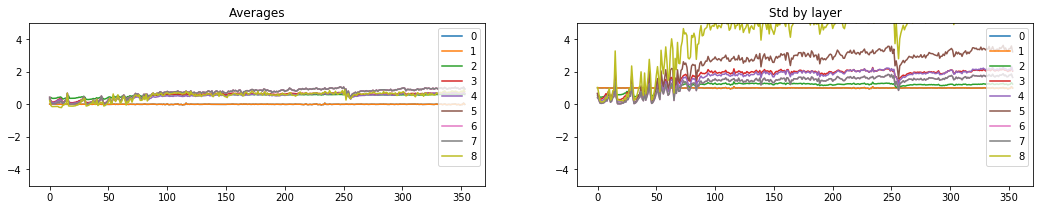

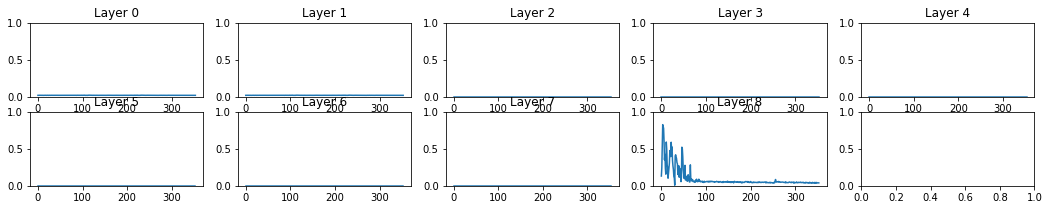

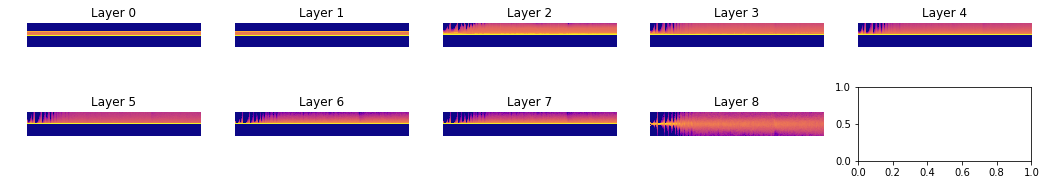

In [0]:
"""train: [1.271331015625, tensor(0.5817, device='cuda:0')]
valid: [0.2440294189453125, tensor(0.9236, device='cuda:0')]
train: [0.201713984375, tensor(0.9388, device='cuda:0')]
valid: [0.12756978759765625, tensor(0.9609, device='cuda:0')]
train: [0.1192737890625, tensor(0.9629, device='cuda:0')]
valid: [0.09299730224609375, tensor(0.9710, device='cuda:0')]
"""
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v2_)
train_and_show_telemetry(model)

train: [nan, tensor(0.1050, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


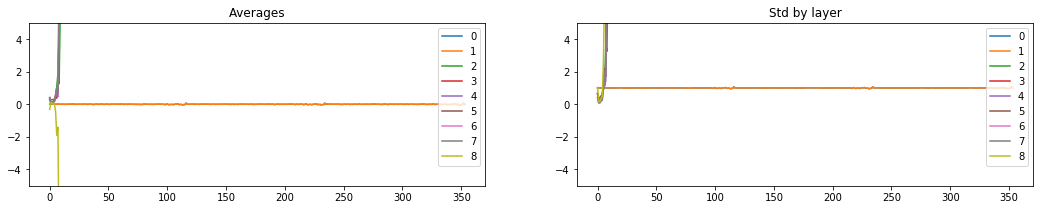

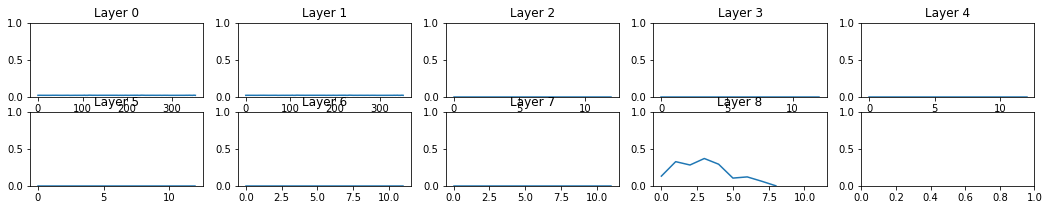

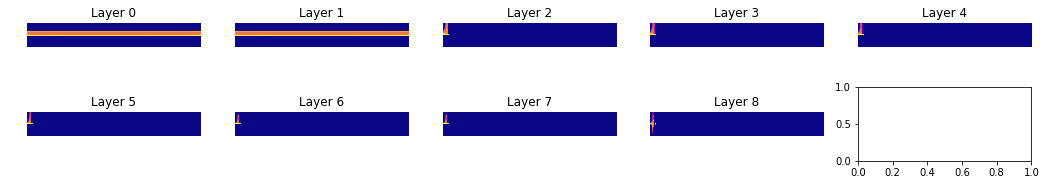

In [0]:
# Another run just in case
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v2_)
train_and_show_telemetry(model)

In [0]:
lsuv_telemetry

{'module: ': {'skipped': True},
 'module: 0': {'skipped': True},
 'module: 1': {'skipped': True},
 'module: 2': {'skipped': True},
 'module: 2.conv': {'hook_called': True,
  'in_mean': -0.07252306491136551,
  'in_std': 0.9052676558494568,
  'out_means': [-0.035330723971128464, -5.013176291868149e-07],
  'out_means_std': [-5.013176291868149e-07,
   -0.00036409570020623505,
   -0.00037274323403835297],
  'out_stds': [0.6127342581748962, 0.9908885955810547, 0.9998941421508789],
  'skipped': False},
 'module: 2.relu': {'skipped': True},
 'module: 3': {'skipped': True},
 'module: 3.conv': {'hook_called': True,
  'in_mean': 0.29049691557884216,
  'in_std': 0.5569754242897034,
  'out_means': [-0.07154836505651474, -6.393814544480847e-08],
  'out_means_std': [-6.393814544480847e-08,
   -0.06670688837766647,
   -0.0684041753411293],
  'out_stds': [0.41560879349708557, 0.9853488206863403, 0.9998999238014221],
  'skipped': False},
 'module: 3.relu': {'skipped': True},
 'module: 4': {'skipped': Tr

# v3: zero bias, then weights normalization (almost paper style)

In [0]:
"""Note to self: tryin to adjust std & mean within the same cycle leads to the following cyclic behavior
(out_stds=[0.0739094614982605,
  14792.478515625,
  0.0739094614982605,
  ...],
 out_means[-0.0910581722855568,
  3295.766357421875,
  -0.0910581722855568,
  ...])
"""
def lsuv_module_v3_(model, module, model_input, eps = 1e-3, max_iterations=15, telemetry=None):
  if telemetry == None:
    telemetry = {}

  telemetry['hook_called'] = False
  telemetry['out_means'] = []
  telemetry['out_means_std'] = []
  telemetry['out_stds'] = []
  def _hook_func(hook, module, hooked_input, hooked_output):
    hooked_input = hooked_input[0]
    with torch.no_grad():
      if telemetry['hook_called']: return
      else: telemetry['hook_called'] = True

      telemetry['in_std'] = hooked_input[0].data.std().item()
      telemetry['in_mean'] = hooked_input[0].data.mean().item()
      #for i in range(max_iterations):
      #  output = module(hooked_input)
      #  mean = output.data.mean().item()
      #  telemetry['out_means'].append(mean)
      #  if abs(mean) < eps:
      #    break
      # 
      #  module.bias -= mean
      module.bias.data = torch.zeros_like(module.bias)

      for i in range(max_iterations):
        output = module(hooked_input)
        std = output.data.std().item()
        telemetry['out_stds'].append(std)
        telemetry['out_means_std'].append(output.data.mean().item())
        if abs(std-1) < eps:
          break

        module.weight.data /= std

  try:
    hook = Hook(module, _hook_func)
    model(model_input)
  finally:
    hook.remove()

model = get_my_model()
telemetry = {}
lsuv_module_v3_(model, model[2].conv, x, telemetry=telemetry)
test_eq(len(telemetry['out_stds']) > 0, True)
test_eq(len(telemetry['out_stds']) <= 6, True)

In [0]:
telemetry

{'hook_called': True,
 'in_mean': -0.07252306491136551,
 'in_std': 0.9052676558494568,
 'out_means': [],
 'out_means_std': [-0.0074144396930933, -0.01509162038564682],
 'out_stds': [0.4912901818752289, 1.0]}

In [0]:
model = get_my_model()
telemetry = {}
lsuv_model_(model, x, telemetry=telemetry, module_func=lsuv_module_v3_)
telemetry

{'module: ': {'skipped': True},
 'module: 0': {'skipped': True},
 'module: 1': {'skipped': True},
 'module: 2': {'skipped': True},
 'module: 2.conv': {'hook_called': True,
  'in_mean': -0.07252306491136551,
  'in_std': 0.9052676558494568,
  'out_means': [],
  'out_means_std': [0.0006592366262339056, 0.0010392776457592845],
  'out_stds': [0.634604275226593, 0.9999999403953552],
  'skipped': False},
 'module: 2.relu': {'skipped': True},
 'module: 3': {'skipped': True},
 'module: 3.conv': {'hook_called': True,
  'in_mean': 0.29934340715408325,
  'in_std': 0.5233524441719055,
  'out_means': [],
  'out_means_std': [-0.08888581395149231, -0.28633207082748413],
  'out_stds': [0.31042852997779846, 0.9999999403953552],
  'skipped': False},
 'module: 3.relu': {'skipped': True},
 'module: 4': {'skipped': True},
 'module: 4.conv': {'hook_called': True,
  'in_mean': 0.23358987271785736,
  'in_std': 0.46755871176719666,
  'out_means': [],
  'out_means_std': [0.009013859555125237, 0.03388950973749161

## Result

train: [2.2927915625, tensor(0.1461, device='cuda:0')]
valid: [2.255394921875, tensor(0.1942, device='cuda:0')]
train: [1.22456015625, tensor(0.5887, device='cuda:0')]
valid: [0.3779235107421875, tensor(0.8868, device='cuda:0')]
train: [0.23201734375, tensor(0.9277, device='cuda:0')]
valid: [0.15107847900390625, tensor(0.9527, device='cuda:0')]


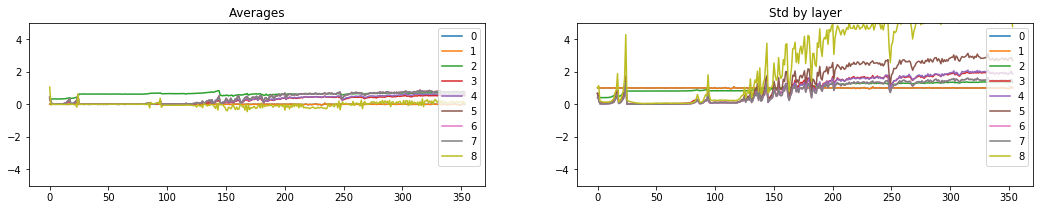

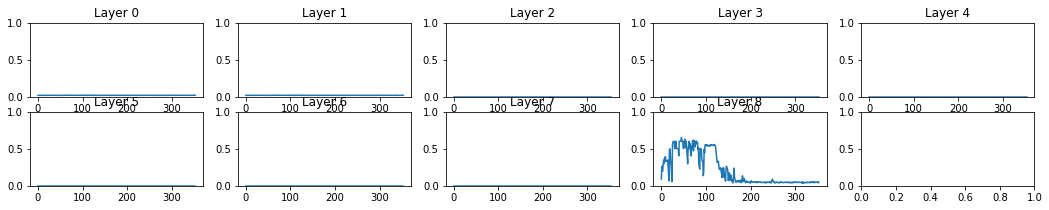

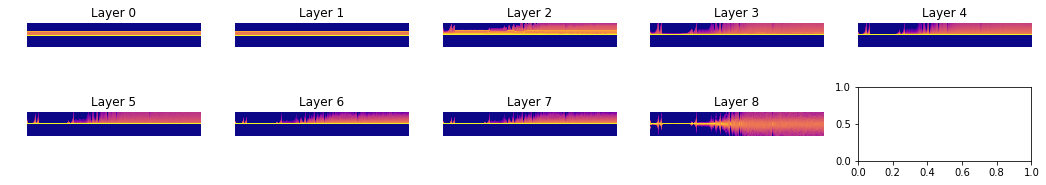

In [0]:
""" Am I dreaming or missed a thing?

train: [3167548782.67392, tensor(0.1101, device='cuda:0')]
valid: [2.3020345703125, tensor(0.1064, device='cuda:0')]
train: [2.3015034375, tensor(0.1136, device='cuda:0')]
valid: [2.30341484375, tensor(0.1064, device='cuda:0')]
train: [2.301503125, tensor(0.1136, device='cuda:0')]
valid: [2.3016744140625, tensor(0.1064, device='cuda:0')]

or 

train: [2.28018, tensor(0.1920, device='cuda:0')]
valid: [2.211220703125, tensor(0.2151, device='cuda:0')]
train: [1.19418484375, tensor(0.5987, device='cuda:0')]
valid: [0.658178076171875, tensor(0.7703, device='cuda:0')]
train: [0.457200625, tensor(0.8529, device='cuda:0')]
valid: [0.2495910400390625, tensor(0.9227, device='cuda:0')]"""
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v3_)
train_and_show_telemetry(model)

train: [nan, tensor(0.0997, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


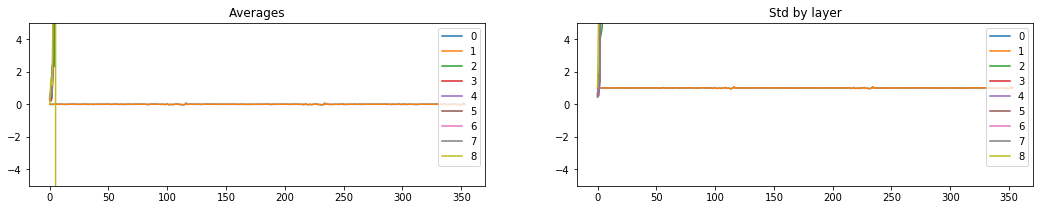

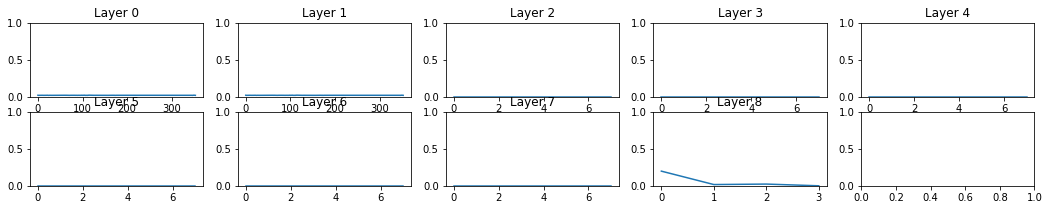

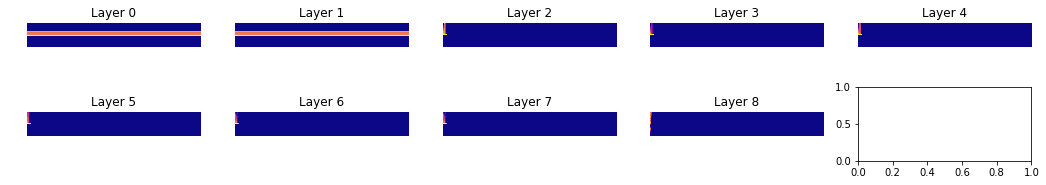

In [0]:
# Another run just in case
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v3_)
train_and_show_telemetry(model)

In [0]:
"""Fun thing: metrics for above sort of look normal but result sucks, something is waaaay off, can be a puzzle!
Skipping 
Skipping 0
Skipping 1
Skipping 2
Tuned 2.conv: mean: 0.011985446326434612 std: 0.9997062087059021
 means: [0.012304319068789482, 0.012273049913346767, 0.012233315035700798, 0.012193841859698296, 0.012149345129728317, 0.01212589256465435, 0.012108179740607738, 0.012092533521354198, 0.012078891508281231, 0.01206248439848423, 0.012046093121170998, 0.012029238045215607, 0.012014483101665974, 0.011999847367405891, 0.011985446326434612] std: [0.09558939933776855, 0.13473549485206604, 0.6443172097206116, 0.9866802096366882, 0.9997062087059021]
Skipping 2.relu
Skipping 3
Tuned 3.conv: mean: 0.24987506866455078 std: 0.9999668002128601
 means: [0.2800482213497162, 0.2778030037879944, 0.2756524085998535, 0.2735946476459503, 0.271605908870697, 0.2695592939853668, 0.26752179861068726, 0.2653965353965759, 0.26316991448402405, 0.260812908411026, 0.25858283042907715, 0.25640442967414856, 0.2542356550693512, 0.25205421447753906, 0.24987506866455078] std: [0.9516087174415588, 1.0013232231140137, 0.9999668002128601]
Skipping 3.relu
Skipping 4
Tuned 4.conv: mean: 0.19399942457675934 std: 1.000223159790039
 means: [0.26125568151474, 0.2554106116294861, 0.24969163537025452, 0.24429568648338318, 0.23911955952644348, 0.23378491401672363, 0.22835180163383484, 0.22312264144420624, 0.21813197433948517, 0.21333661675453186, 0.20899148285388947, 0.2049100697040558, 0.2010728120803833, 0.19742897152900696, 0.19399942457675934] std: [0.8644272089004517, 1.0175645351409912, 0.998038649559021, 1.000223159790039]
Skipping 4.relu
Skipping 5
Tuned 5.conv: mean: 0.1032949686050415 std: 1.0006436109542847
 means: [0.2241034209728241, 0.20658838748931885, 0.19140073657035828, 0.17807063460350037, 0.16641315817832947, 0.15631258487701416, 0.14754441380500793, 0.1398543119430542, 0.13300542533397675, 0.1268174797296524, 0.12123088538646698, 0.11618179082870483, 0.11153824627399445, 0.10728070884943008, 0.1032949686050415] std: [0.5485186576843262, 1.2805862426757812, 0.9156915545463562, 1.0339174270629883, 0.987694501876831, 1.004637598991394, 0.9982768297195435, 1.0006436109542847]
Skipping 5.relu
Skipping 6
Skipping 7
Tuned 8: mean: -2.9802322831784522e-09 std: 1.0006436109542847
 means: [0.19446006417274475, -2.9802322831784522e-09] std: [1.0006436109542847]
train: [2.744035625, tensor(0.1127, device='cuda:0')]
valid: [2.3026060546875, tensor(0.1064, device='cuda:0')]
train: [2.3014946875, tensor(0.1136, device='cuda:0')]
valid: [2.303403515625, tensor(0.1064, device='cuda:0')]
train: [2.30161375, tensor(0.1129, device='cuda:0')]
valid: [2.3028357421875, tensor(0.1064, device='cuda:0')]


TLDR: was param name copypasta, discovered by logging input mean/std and seeing they're exactly the same between layers

{'module: ': {'skipped': True},
 'module: 0': {'skipped': True},
 'module: 1': {'skipped': True},
 'module: 2': {'skipped': True},
 'module: 2.conv': {'hook_called': True,
  'in_mean': 0.13350103795528412,
  'in_std': 0.31056100130081177,
  'out_means': [-0.08657996356487274],
  'out_stds': [0.9997897148132324],
  'skipped': False},
 'module: 2.relu': {'skipped': True},
 'module: 3': {'skipped': True},
 'module: 3.conv': {'hook_called': True,
  'in_mean': 0.13350103795528412,
  'in_std': 0.31056100130081177,
  'out_means': [-0.08580011874437332, -0.08601481467485428],
  'out_stds': [0.9979162812232971, 1.0000662803649902],
  'skipped': False},
 'module: 3.relu': {'skipped': True},
 'module: 4': {'skipped': True},
 'module: 4.conv': {'hook_called': True,
  'in_mean': 0.13350103795528412,
  'in_std': 0.31056100130081177,
  'out_means': [-0.08605282008647919, -0.0857296735048294],
  'out_stds': [1.0031473636627197, 0.9999099373817444],
  'skipped': False},
 'module: 4.relu': {'skipped': True},
 'module: 5': {'skipped': True},
 'module: 5.conv': {'hook_called': True,
  'in_mean': 0.13350103795528412,
  'in_std': 0.31056100130081177,
  'out_means': [-0.08696146309375763, -0.08714123070240021],
  'out_stds': [0.9982519745826721, 1.0000534057617188],
  'skipped': False},
 'module: 5.relu': {'skipped': True},
 'module: 6': {'skipped': True},
 'module: 7': {'skipped': True},
 'module: 8': {'hook_called': True,
  'in_mean': 0.13350103795528412,
  'in_std': 0.31056100130081177,
  'out_means': [-0.10284571349620819, -0.09940584003925323],
  'out_stds': [1.0346043109893799, 1.0],
  'skipped': False}}""";

In [0]:
lsuv_telemetry

{'module: ': {'skipped': True},
 'module: 0': {'skipped': True},
 'module: 1': {'skipped': True},
 'module: 2': {'skipped': True},
 'module: 2.conv': {'hook_called': True,
  'in_mean': -0.07252306491136551,
  'in_std': 0.9052676558494568,
  'out_means': [],
  'out_means_std': [-0.006155198439955711, -0.010608792304992676],
  'out_stds': [0.5801968574523926, 1.0],
  'skipped': False},
 'module: 2.relu': {'skipped': True},
 'module: 3': {'skipped': True},
 'module: 3.conv': {'hook_called': True,
  'in_mean': 0.27688372135162354,
  'in_std': 0.5480963587760925,
  'out_means': [],
  'out_means_std': [-0.03931614011526108, -0.10172741115093231],
  'out_stds': [0.38648536801338196, 1.0],
  'skipped': False},
 'module: 3.relu': {'skipped': True},
 'module: 4': {'skipped': True},
 'module: 4.conv': {'hook_called': True,
  'in_mean': 0.25999245047569275,
  'in_std': 0.4982168674468994,
  'out_means': [],
  'out_means_std': [0.02011982537806034, 0.06601490080356598],
  'out_stds': [0.30477690696

# v4: zero bias, orthogonal weights, normalize (paper style)

In [0]:
"""Note to self: tryin to adjust std & mean within the same cycle leads to the following cyclic behavior
(out_stds=[0.0739094614982605,
  14792.478515625,
  0.0739094614982605,
  ...],
 out_means[-0.0910581722855568,
  3295.766357421875,
  -0.0910581722855568,
  ...])
"""
def lsuv_module_v4_(model, module, model_input, eps = 1e-3, max_iterations=15, telemetry=None):
  if telemetry == None:
    telemetry = {}

  telemetry['hook_called'] = False
  telemetry['out_means'] = []
  telemetry['out_means_std'] = []
  telemetry['out_stds'] = []
  def _hook_func(hook, module, hooked_input, hooked_output):
    hooked_input = hooked_input[0]
    with torch.no_grad():
      if telemetry['hook_called']: return
      else: telemetry['hook_called'] = True

      telemetry['in_std'] = hooked_input[0].data.std().item()
      telemetry['in_mean'] = hooked_input[0].data.mean().item()
      #for i in range(max_iterations):
      #  output = module(hooked_input)
      #  mean = output.data.mean().item()
      #  telemetry['out_means'].append(mean)
      #  if abs(mean) < eps:
      #    break
      # 
      #  module.bias -= mean
      module.bias.data = torch.zeros_like(module.bias)

      from torch.nn import init
      init.orthogonal_(module.weight.data)
      for i in range(max_iterations):
        output = module(hooked_input)
        std = output.data.std().item()
        telemetry['out_stds'].append(std)
        telemetry['out_means_std'].append(output.data.mean().item())
        if abs(std-1) < eps:
          break

        module.weight.data /= std

  try:
    hook = Hook(module, _hook_func)
    model(model_input)
  finally:
    hook.remove()

model = get_my_model()
telemetry = {}
lsuv_module_v4_(model, model[2].conv, x, telemetry=telemetry)
test_eq(len(telemetry['out_stds']) > 0, True)
test_eq(len(telemetry['out_stds']) <= 6, True)

In [0]:
telemetry

{'hook_called': True,
 'in_mean': -0.07252306491136551,
 'in_std': 0.9052676558494568,
 'out_means': [],
 'out_means_std': [0.005886933766305447, 0.005527931731194258],
 'out_stds': [1.064775824546814, 1.0]}

## Result

train: [2.74247625, tensor(0.1545, device='cuda:0')]
valid: [2.3025787109375, tensor(0.1064, device='cuda:0')]
train: [2.30154921875, tensor(0.1136, device='cuda:0')]
valid: [2.3017306640625, tensor(0.1064, device='cuda:0')]
train: [2.301664375, tensor(0.1136, device='cuda:0')]
valid: [2.3021119140625, tensor(0.1064, device='cuda:0')]


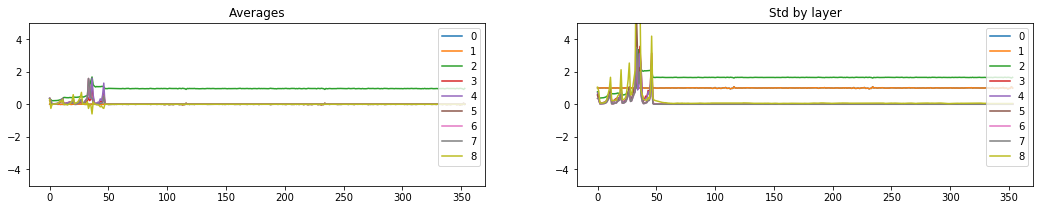

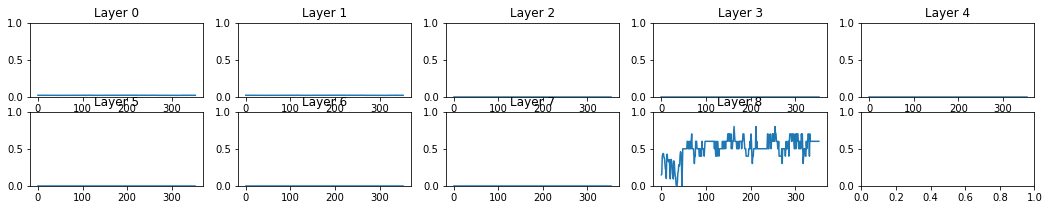

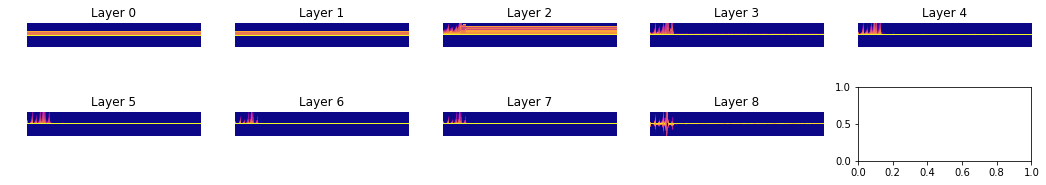

In [0]:
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v4_)
train_and_show_telemetry(model)

In [0]:
lsuv_telemetry

{'module: ': {'skipped': True},
 'module: 0': {'skipped': True},
 'module: 1': {'skipped': True},
 'module: 2': {'skipped': True},
 'module: 2.conv': {'hook_called': True,
  'in_mean': -0.07252306491136551,
  'in_std': 0.9052676558494568,
  'out_means': [],
  'out_means_std': [0.011302833445370197, 0.01027513388544321],
  'out_stds': [1.1000596284866333, 1.0],
  'skipped': False},
 'module: 2.relu': {'skipped': True},
 'module: 3': {'skipped': True},
 'module: 3.conv': {'hook_called': True,
  'in_mean': 0.2941729426383972,
  'in_std': 0.637190580368042,
  'out_means': [],
  'out_means_std': [-0.1090712770819664, -0.11967160552740097],
  'out_stds': [0.9114204049110413, 1.0],
  'skipped': False},
 'module: 3.relu': {'skipped': True},
 'module: 4': {'skipped': True},
 'module: 4.conv': {'hook_called': True,
  'in_mean': 0.20337167382240295,
  'in_std': 0.46097761392593384,
  'out_means': [],
  'out_means_std': [0.03034825250506401, 0.0635310560464859],
  'out_stds': [0.4776915907859802, 

train: [1.8263496875, tensor(0.3731, device='cuda:0')]
valid: [0.622006298828125, tensor(0.7911, device='cuda:0')]
train: [0.2842523828125, tensor(0.9103, device='cuda:0')]
valid: [0.18741763916015625, tensor(0.9454, device='cuda:0')]
train: [0.1530639453125, tensor(0.9526, device='cuda:0')]
valid: [0.177091748046875, tensor(0.9446, device='cuda:0')]


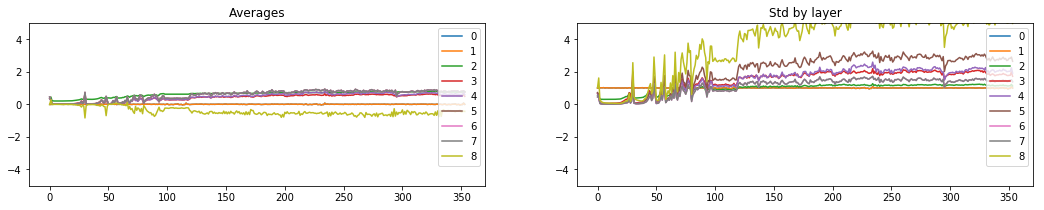

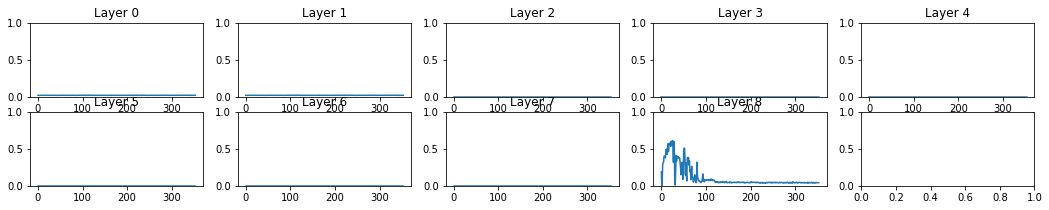

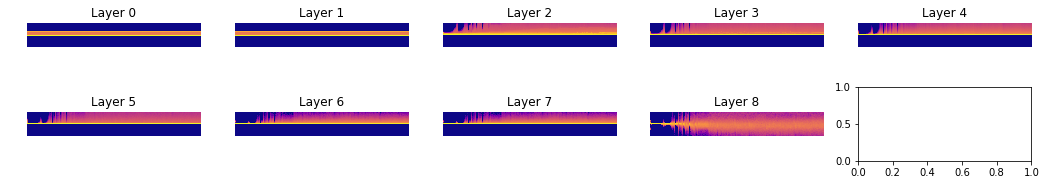

In [0]:
# Another run just in case
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v4_)
train_and_show_telemetry(model)

train: [2.342918125, tensor(0.1221, device='cuda:0')]
valid: [2.301137109375, tensor(0.1064, device='cuda:0')]
train: [2.28512109375, tensor(0.1429, device='cuda:0')]
valid: [2.2913072265625, tensor(0.1233, device='cuda:0')]
train: [1.6939084375, tensor(0.4296, device='cuda:0')]
valid: [0.724075537109375, tensor(0.7701, device='cuda:0')]


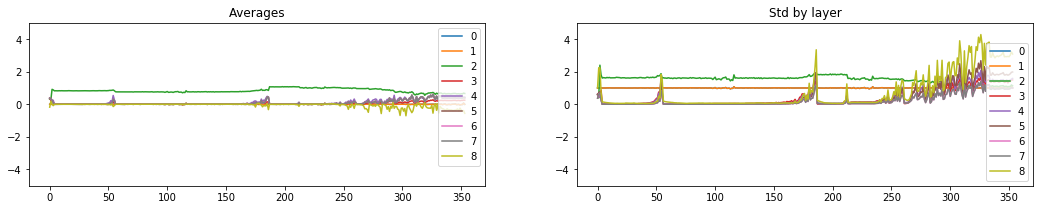

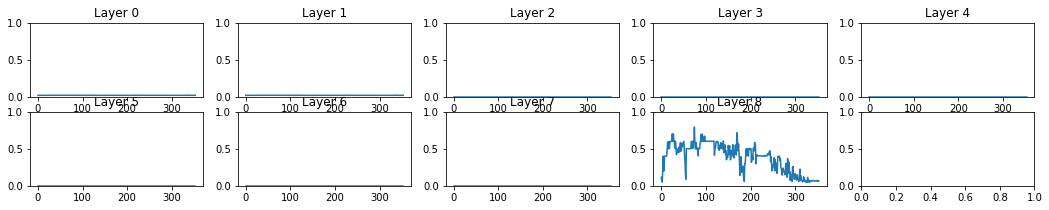

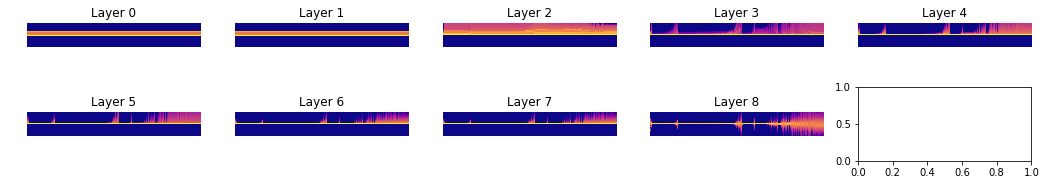

In [0]:
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v4_)
train_and_show_telemetry(model)

train: [2.4560065625, tensor(0.1270, device='cuda:0')]
valid: [2.303311328125, tensor(0.1064, device='cuda:0')]
train: [2.30167515625, tensor(0.1136, device='cuda:0')]
valid: [2.302088671875, tensor(0.1064, device='cuda:0')]
train: [2.30163921875, tensor(0.1130, device='cuda:0')]
valid: [2.3025146484375, tensor(0.1064, device='cuda:0')]


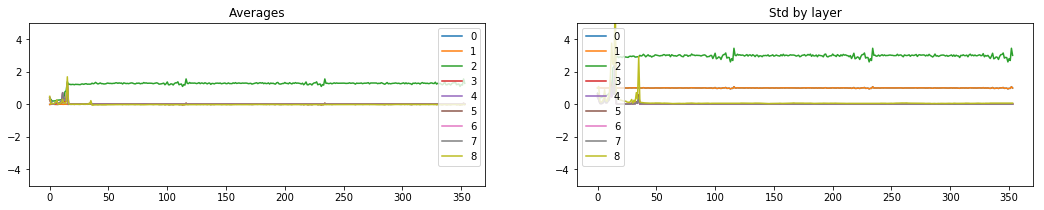

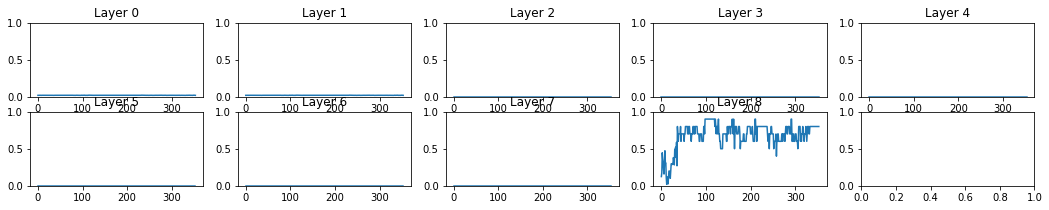

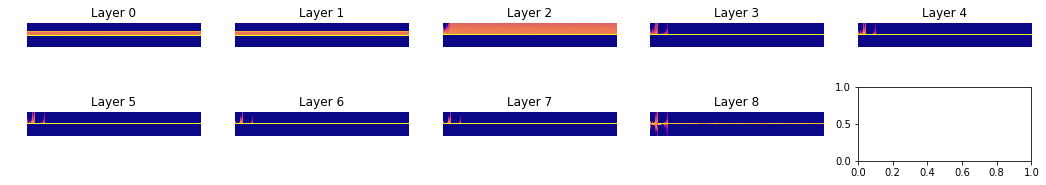

In [0]:
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v4_)
train_and_show_telemetry(model)

In [0]:
lsuv_telemetry

{'module: ': {'skipped': True},
 'module: 0': {'skipped': True},
 'module: 1': {'skipped': True},
 'module: 2': {'skipped': True},
 'module: 2.conv': {'hook_called': True,
  'in_mean': -0.07252306491136551,
  'in_std': 0.9052676558494568,
  'out_means': [],
  'out_means_std': [0.010288643650710583, 0.01032099686563015],
  'out_stds': [0.9968551993370056, 1.0],
  'skipped': False},
 'module: 2.relu': {'skipped': True},
 'module: 3': {'skipped': True},
 'module: 3.conv': {'hook_called': True,
  'in_mean': 0.31066757440567017,
  'in_std': 0.5930299758911133,
  'out_means': [],
  'out_means_std': [-0.08552518486976624, -0.10145682096481323],
  'out_stds': [0.8429706692695618, 1.0],
  'skipped': False},
 'module: 3.relu': {'skipped': True},
 'module: 4': {'skipped': True},
 'module: 4.conv': {'hook_called': True,
  'in_mean': 0.2449280321598053,
  'in_std': 0.4969896078109741,
  'out_means': [],
  'out_means_std': [-0.04702965170145035, -0.0894724652171135],
  'out_stds': [0.525632679462432

In [0]:
model.cpu()
module_1_out = model[1](model[0](x))
module_2_out = model[2](module_1_out)
stats(module_2_out)

Stats(mean=tensor(1.2343, grad_fn=<MeanBackward0>), std=tensor(2.9095, grad_fn=<StdBackward0>))

In [0]:
model[2].conv.weight.requires_grad, model[2].conv.bias.requires_grad

(True, True)

train: [0.98087171875, tensor(0.6845, device='cuda:0')]
valid: [0.22168671875, tensor(0.9319, device='cuda:0')]
train: [0.17944150390625, tensor(0.9458, device='cuda:0')]
valid: [0.14349212646484374, tensor(0.9600, device='cuda:0')]
train: [0.130176064453125, tensor(0.9600, device='cuda:0')]
valid: [0.10439580078125, tensor(0.9702, device='cuda:0')]


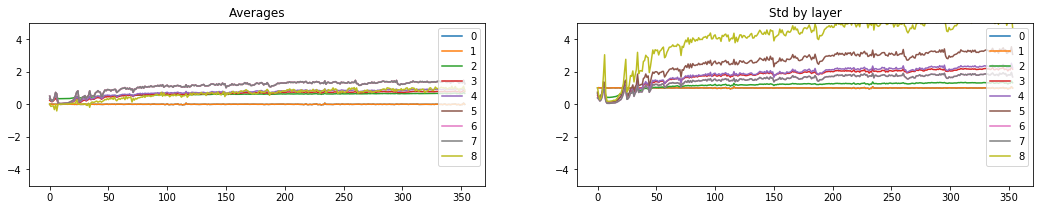

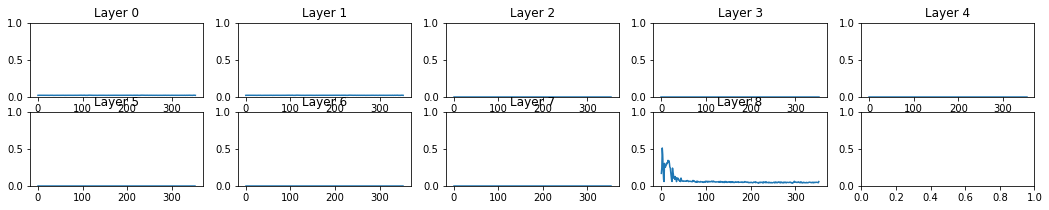

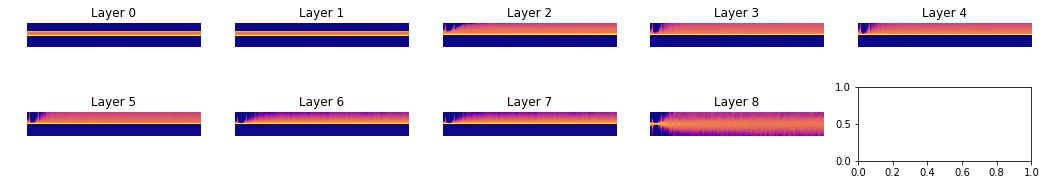

In [0]:
model = get_my_model()
lsuv_telemetry = {}
lsuv_model_(model, x, lsuv_telemetry, module_func=lsuv_module_v4_)
train_and_show_telemetry(model, lr=0.4)

In [0]:
%%html
# Note to self: training with lr=1 would lead to nan / ~random / bad results in roughly 1/2 cases with all the methods tried (lr=0.4 doesn't seem to have that problem)
# Even layer output stats init looking good was not a guarantee
<br/><img src="https://raw.githubusercontent.com/cluePrints/fastai-v3-notes/master/images/07a_lsuv_blow.png" width="300"/>
<br/><img src="https://raw.githubusercontent.com/cluePrints/fastai-v3-notes/master/images/07a_lsuv_stuck.png" width="300"/>


# Bottom